# TextEmotionNB.ipynb

This notebook:
1. Load prepared/cleaned text data from `data/data_clean/clean.csv`
2. Perform a stratified 70/15/15 split and write splits to `data/data_split/` (one time)
3. Define a reusable **run_trial(config, tag)** that:
  - Makes a unique trial directory with timestamp + provided tag.
  - Loads train/val/test from `/data/data_split/`.
  - Builds TF-IDF using provided params, fits on train text.
  - Trains MultinomialNB using provided params.
  - Evaluates accuracy + macro F1 on train/val/test.
  - Creates/saves confusion matrix plot, metrics.json, classification_report.txt, metadata, and both joblibs.
  - Updates `/artifacts/outputs/leaderboard.csv`.
4. Define optimization framework for experimentation: **optimizations only** (override config keys), compare in leaderboard/plots.


## Setup Imports, fixed seed, paths

In [1]:
import sys, os, platform, json, math, time, uuid, random, shutil
from datetime import datetime
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from wordcloud import WordCloud

import joblib

# Environment / version logging
print("Python:", sys.version)
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)

import sklearn
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", plt.matplotlib.__version__)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths
DATA = Path("../data")
DATA_CLEAN_PATH = DATA / "data_clean/clean.csv"
SPLIT_DIR       = DATA / "data_split"
ART = Path("../artifacts")
MODELS      = ART / "models"
TRIALS_ROOT = ART / "trials"
OUTPUTS_DIR = ART / "outputs"  # leaderboard lives here

for p in [SPLIT_DIR, MODELS, TRIALS_ROOT, OUTPUTS_DIR]: p.mkdir(parents=True, exist_ok=True)

assert DATA_CLEAN_PATH.exists(), f"Missing input data: {DATA_CLEAN_PATH}"
print("Input data found:", DATA_CLEAN_PATH)


Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
OS: Windows-11-10.0.26200-SP0
NumPy: 2.2.6
pandas: 2.2.3
scikit-learn: 1.6.1
matplotlib: 3.9.4
Input data found: ..\data\data_clean\clean.csv


## Create and save stratified splits (70/15/15)

In [2]:
# Stratified 70/15/15 split with idempotence / reproducibility

train_path = SPLIT_DIR / "train.csv"
val_path   = SPLIT_DIR / "val.csv"
test_path  = SPLIT_DIR / "test.csv"

if train_path.exists() and val_path.exists() and test_path.exists():
    # Splits already exist -> DO NOT RESPLIT.
    # Just load them and print diagnostics
    print("[split] Existing splits detected. Skipping new split.")
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)

else:
    # No saved split yet -> create once and persist.
    print("[split] No existing split found. Creating new stratified split...")

    # Load cleaned data
    df = pd.read_csv(DATA_CLEAN_PATH)

    required_cols = {"text", "label_id", "label_name"}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(
            f"Expected columns {required_cols}, but missing {missing_cols} in {DATA_CLEAN_PATH}"
        )

    print("Total samples:", len(df))

    # Show overall label distribution
    print("\nClass distribution (full data) by label_id:")
    print(df["label_id"].value_counts(normalize=True))

    print("\nClass distribution (full data) by label_name:")
    print(df["label_name"].value_counts(normalize=True))

    # First stratified split: train (70%) vs temp (30%)
    splitter_main = StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.30,
        random_state=SEED
    )

    for train_idx, temp_idx in splitter_main.split(df, df["label_id"]):
        train_df = df.iloc[train_idx].reset_index(drop=True)
        temp_df  = df.iloc[temp_idx].reset_index(drop=True)

    # Second split: val/test = 15%/15% of total (half/half of temp)
    splitter_temp = StratifiedShuffleSplit(
        n_splits=1,
        test_size=0.5,
        random_state=SEED
    )

    for val_idx, test_idx in splitter_temp.split(temp_df, temp_df["label_id"]):
        val_df  = temp_df.iloc[val_idx].reset_index(drop=True)
        test_df = temp_df.iloc[test_idx].reset_index(drop=True)

    # Persist to disk so future runs reuse the SAME split
    cols_to_keep = ["text", "label_id", "label_name"]
    train_df[cols_to_keep].to_csv(train_path, index=False)
    val_df[cols_to_keep].to_csv(val_path, index=False)
    test_df[cols_to_keep].to_csv(test_path, index=False)

    print(f"[split] Wrote {train_path}, {val_path}, {test_path}")

# Print diagnostics every run to verify stability

print("\n[split] Final split sizes:")
print("  train:", len(train_df))
print("  val:  ", len(val_df))
print("  test: ", len(test_df))

print("\n[split] Class distribution by split (label_id):")
for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    dist = part["label_id"].value_counts(normalize=True)
    print(f"{name}:\n{dist}\n")

print("[split] Class distribution by split (label_name):")
for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    dist_name = part["label_name"].value_counts(normalize=True)
    print(f"{name}:\n{dist_name}\n")



[split] No existing split found. Creating new stratified split...
Total samples: 416123

Class distribution (full data) by label_id:
label_id
1    0.338311
0    0.290753
3    0.137543
4    0.114543
2    0.082901
5    0.035949
Name: proportion, dtype: float64

Class distribution (full data) by label_name:
label_name
joy         0.338311
sadness     0.290753
anger       0.137543
fear        0.114543
love        0.082901
surprise    0.035949
Name: proportion, dtype: float64
[split] Wrote ..\data\data_split\train.csv, ..\data\data_split\val.csv, ..\data\data_split\test.csv

[split] Final split sizes:
  train: 291286
  val:   62418
  test:  62419

[split] Class distribution by split (label_id):
train:
label_id
1    0.338310
0    0.290752
3    0.137545
4    0.114544
2    0.082901
5    0.035947
Name: proportion, dtype: float64

val:
label_id
1    0.338316
0    0.290749
3    0.137540
4    0.114534
2    0.082909
5    0.035951
Name: proportion, dtype: float64

test:
label_id
1    0.338310
0    0

## Define Model Builder Utility **run_trial(config,tag)**

This utility will provide the following functionality:
- Makes a unique trial directory with timestamp + provided tag.
- Loads train/val/test from `/data/data_split/`.
- Builds TF-IDF using provided params, fits on train text.
- Trains MultinomialNB using provided params.
- Evaluates accuracy + macro F1 on train/val/test.
- Creates/saves confusion matrix plot, `metrics.json`, `classification_report.txt`, metadata, and both joblibs.
- Updates `/artifacts/outputs/leaderboard.csv`.

In [3]:
def run_trial(
    trial_tag: str,
    tfidf_params: dict,
    nb_params: dict,
    seed: int = SEED
):
    """
    Train/evaluate a single trial of TF-IDF + MultinomialNB and persist artifacts.
    Generates:
      - confusion_matrix.png
      - per_class_scores.png               (precision/recall/f1 per class)
      - top_misclassifications.csv         (most confident wrong predictions)
      - top_words_per_class.json           (top tokens per class)
      - wordcloud_class_<classid>.png      (word clouds for each class, if wordcloud is available)
      - metrics.json
      - classification_report.txt
      - training_metadata.json
      - tfidf.joblib
      - nb.joblib
    Updates global leaderboard.csv.
    """

    # Create trial directory
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    trial_dir = TRIALS_ROOT / f"{timestamp}_{trial_tag}"
    trial_dir.mkdir(parents=True, exist_ok=True)
    print(f"[run_trial] Trial directory: {trial_dir}")

    # Load splits
    train_df = pd.read_csv(SPLIT_DIR / "train.csv")
    val_df   = pd.read_csv(SPLIT_DIR / "val.csv")
    test_df  = pd.read_csv(SPLIT_DIR / "test.csv")

    # sanity check columns
    for req_col in ["text", "label_id", "label_name"]:
        if req_col not in train_df.columns:
            raise ValueError(f"train.csv missing '{req_col}'")
        if req_col not in val_df.columns:
            raise ValueError(f"val.csv missing '{req_col}'")
        if req_col not in test_df.columns:
            raise ValueError(f"test.csv missing '{req_col}'")

    X_train_raw = train_df["text"].astype(str).tolist()
    X_val_raw   = val_df["text"].astype(str).tolist()
    X_test_raw  = test_df["text"].astype(str).tolist()

    # numeric class IDs for modeling
    y_train = train_df["label_id"].tolist()
    y_val   = val_df["label_id"].tolist()
    y_test  = test_df["label_id"].tolist()

    # Build numeric -> human mapping
    label_lookup_records = (
        train_df[["label_id", "label_name"]]
        .drop_duplicates()
        .sort_values("label_id")
        .to_dict(orient="records")
    )
    id_to_name = {r["label_id"]: r["label_name"] for r in label_lookup_records}

    # Vectorize
    tfidf = TfidfVectorizer(**tfidf_params)

    X_train_vec = tfidf.fit_transform(X_train_raw)
    X_val_vec   = tfidf.transform(X_val_raw)
    X_test_vec  = tfidf.transform(X_test_raw)

    print("[run_trial] Vector shapes:",
          "train", X_train_vec.shape,
          "val",   X_val_vec.shape,
          "test",  X_test_vec.shape)

    # Train NB
    nb = MultinomialNB(**nb_params)
    nb.fit(X_train_vec, y_train)

    y_train_pred = nb.predict(X_train_vec)
    y_val_pred   = nb.predict(X_val_vec)
    y_test_pred  = nb.predict(X_test_vec)

    y_test_proba = nb.predict_proba(X_test_vec)  # for misclass analysis

    # Metrics (scalar)
    def summarize_split(y_true, y_pred):
        return {
            "accuracy": float(accuracy_score(y_true, y_pred)),
            "macro_f1": float(f1_score(y_true, y_pred, average="macro"))
        }

    train_metrics = summarize_split(y_train, y_train_pred)
    val_metrics   = summarize_split(y_val,   y_val_pred)
    test_metrics  = summarize_split(y_test,  y_test_pred)

    print("[run_trial] Performance:")
    print("  Train:", train_metrics)
    print("  Val:  ", val_metrics)
    print("  Test: ", test_metrics)

    # Classification report
    labels_sorted = sorted(list(set(y_test)))
    target_names = [id_to_name.get(lbl, str(lbl)) for lbl in labels_sorted]

    cls_report_dict = classification_report(
        y_test,
        y_test_pred,
        labels=labels_sorted,
        target_names=target_names,   # <-- human-readable class names
        output_dict=True,
        digits=4
    )

    cls_report_text = classification_report(
        y_test,
        y_test_pred,
        labels=labels_sorted,
        target_names=target_names,   # <-- human-readable class names
        digits=4
    )
    
    # Print classification report to screen
    print("\n=== Classification Report (Test Set) ===")
    print(cls_report_text)
    print("=" * 50)

    # Create onfusion matrices (raw and normalized)
    labels_sorted = sorted(list(set(y_test)))
    target_names = [id_to_name.get(lbl, str(lbl)) for lbl in labels_sorted]

    # Compute raw and normalized confusion matrices
    cm_raw = confusion_matrix(y_test, y_test_pred, labels=labels_sorted)
    cm_norm = confusion_matrix(
        y_test, y_test_pred, labels=labels_sorted, normalize="true"
    )

    # Raw Confusion Matrix
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm_raw, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(labels_sorted))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45, ha="right")
    ax.set_yticklabels(target_names)

    # Annotate cell values
    thresh = cm_raw.max() * 0.6 if cm_raw.max() != 0 else 0
    for i in range(cm_raw.shape[0]):
        for j in range(cm_raw.shape[1]):
            ax.text(
                j, i, format(cm_raw[i, j], "d"),
                ha="center", va="center",
                color="white" if cm_raw[i, j] > thresh else "black"
            )

    ax.set_ylabel("True class")
    ax.set_xlabel("Predicted class")
    plt.tight_layout()

    cm_raw_path = trial_dir / "confusion_matrix_raw.png"
    plt.savefig(cm_raw_path, dpi=300)
    plt.show()
    plt.close(fig)

    # Normalized Confusion Matrix
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix (normalized)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45, ha="right")
    ax.set_yticklabels(target_names)

    # Annotate with percentages
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(
                j, i, f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black"
            )

    ax.set_ylabel("True class")
    ax.set_xlabel("Predicted class")
    plt.tight_layout()

    cm_norm_path = trial_dir / "confusion_matrix_norm.png"
    plt.savefig(cm_norm_path, dpi=300)
    plt.show()
    plt.close(fig)

    # Keep track of both in metadata
    print(f"[run_trial] Saved raw and normalized confusion matrices to {trial_dir}")

    # Create per-class Precision / Recall / F1 bar chart
    rows = []
    for class_id, class_name in zip(labels_sorted, target_names):
        stats = cls_report_dict[class_name]
        rows.append({
            "class_id": int(class_id),
            "class_name": class_name,
            "precision": stats["precision"],
            "recall": stats["recall"],
            "f1-score": stats["f1-score"],
        })

    per_class_df = pd.DataFrame(rows)

    fig2, ax2 = plt.subplots(figsize=(10,6))
    width = 0.25
    x = np.arange(len(per_class_df))

    ax2.bar(x - width, per_class_df["precision"], width=width, label="precision")
    ax2.bar(x,         per_class_df["recall"],    width=width, label="recall")
    ax2.bar(x + width, per_class_df["f1-score"],  width=width, label="f1-score")

    ax2.set_xticks(x)
    ax2.set_xticklabels(per_class_df["class_name"], rotation=45, ha="right")
    ax2.set_ylim(0, 1.0)
    ax2.set_ylabel("Score")
    ax2.set_title("Per-Class Precision / Recall / F1")
    ax2.grid(axis="y", linestyle="--", alpha=0.5)
    ax2.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),   
        ncol=3,                        
        frameon=True                  
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # add a little room at bottom for legend

    # Save figure to trial directory
    pcs_path = trial_dir / "per_class_scores.png"
    plt.savefig(pcs_path, dpi=300)

    # Display in notebook
    plt.show()
    plt.close(fig2)

    # Create top misclassifications table
    test_pred = np.array(y_test_pred)
    test_true = np.array(y_test)
    conf_scores = y_test_proba.max(axis=1)

    mis_mask = test_pred != test_true
    mis_df = pd.DataFrame({
        "text":        test_df["text"].values,
        "true_id":     test_true,
        "true_name":   [id_to_name.get(t, str(t)) for t in test_true],
        "pred_id":     test_pred,
        "pred_name":   [id_to_name.get(p, str(p)) for p in test_pred],
        "confidence":  conf_scores
    })

    mis_df = mis_df[mis_mask].sort_values("confidence", ascending=False)
    mis_top_path = trial_dir / "top_misclassifications.csv"
    mis_df.head(25).to_csv(mis_top_path, index=False)

    # Determine top words per class
    feature_names = np.array(tfidf.get_feature_names_out())
    n_top = 20
    top_words_per_class = {}

    for i, class_id in enumerate(nb.classes_):
        sorted_idx = np.argsort(nb.feature_log_prob_[i])[::-1][:n_top]
        words = feature_names[sorted_idx].tolist()
        scores = nb.feature_log_prob_[i][sorted_idx].tolist()

        top_words_per_class[str(class_id)] = {
            "class_name": id_to_name.get(int(class_id), str(class_id)),
            "words": words,
            "log_prob": [float(s) for s in scores],
        }

    twpc_path = trial_dir / "top_words_per_class.json"
    with open(twpc_path, "w") as f:
        json.dump(top_words_per_class, f, indent=2)

    # Create word clouds
    for i, class_id in enumerate(nb.classes_):
        weights = np.exp(nb.feature_log_prob_[i])  # convert log prob -> ~prob
        freqs = dict(zip(feature_names, weights))

        wc = WordCloud(
            width=800,
            height=400,
            background_color="white"
        ).generate_from_frequencies(freqs)

        wc_path = trial_dir / f"wordcloud_class_{class_id}.png"
        wc.to_file(wc_path)

    # Persist non-visual artifacts
    tfidf_path = trial_dir / "tfidf.joblib"
    nb_path    = trial_dir / "nb.joblib"
    joblib.dump(tfidf, tfidf_path)
    joblib.dump(nb,    nb_path)

    metrics_all = {
        "train": train_metrics,
        "val":   val_metrics,
        "test":  test_metrics,
    }
    metrics_path = trial_dir / "metrics.json"
    with open(metrics_path, "w") as f:
        json.dump(metrics_all, f, indent=2)

    cls_report_path = trial_dir / "classification_report.txt"
    with open(cls_report_path, "w") as f:
        f.write(cls_report_text)
    
    clean_label_lookup_records = []
    for rec in label_lookup_records:
        clean_label_lookup_records.append({
            "label_id": int(rec["label_id"]),
            "label_name": str(rec["label_name"]),
        })
    
    metadata = {
        "timestamp": timestamp,
        "trial_tag": trial_tag,
        "seed": seed,
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),

        "labels_sorted_numeric": labels_sorted,
        "label_lookup": label_lookup_records,

        "tfidf_params": tfidf_params,
        "nb_params": nb_params,

        "artifacts_dir": str(trial_dir),
        "split_files": {
            "train_csv": str(SPLIT_DIR / "train.csv"),
            "val_csv":   str(SPLIT_DIR / "val.csv"),
            "test_csv":  str(SPLIT_DIR / "test.csv"),
        },
        "visual_artifacts": {
            "confusion_matrix_raw": str(cm_raw_path),
            "confustion_matrix_normalized": str(cm_norm_path),
            "per_class_scores": str(pcs_path),
            "top_misclassifications": str(mis_top_path),
            "top_words_per_class": str(twpc_path),
            "wordclouds_dir": str(trial_dir),
        },
    }
    metadata_path = trial_dir / "training_metadata.json"
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"[run_trial] Saved artifacts to {trial_dir}")

    # Perform leaderboard update
    leaderboard_path = OUTPUTS_DIR / "leaderboard.csv"

    row = {
        "timestamp": timestamp,
        "trial_tag": trial_tag,
        "train_accuracy": train_metrics["accuracy"],
        "train_macro_f1": train_metrics["macro_f1"],
        "val_accuracy":   val_metrics["accuracy"],
        "val_macro_f1":   val_metrics["macro_f1"],
        "test_accuracy":  test_metrics["accuracy"],
        "test_macro_f1":  test_metrics["macro_f1"],
        "artifacts_dir":  str(trial_dir),
        "tfidf_params":   json.dumps(tfidf_params),
        "nb_params":      json.dumps(nb_params),
    }

    if leaderboard_path.exists():
        existing = pd.read_csv(leaderboard_path)
        updated  = pd.concat([existing, pd.DataFrame([row])], ignore_index=True)
        updated.to_csv(leaderboard_path, index=False)
    else:
        pd.DataFrame([row]).to_csv(leaderboard_path, index=False)

    print(f"[run_trial] Leaderboard updated at {leaderboard_path}")

    # Return summary
    return {
        "trial_dir": str(trial_dir),
        "metrics": metrics_all,
        "leaderboard": str(leaderboard_path),
        "label_lookup": clean_label_lookup_records
    }




## Run Baseline

[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-47-32_baseline
[run_trial] Vector shapes: train (291286, 63797) val (62418, 63797) test (62419, 63797)
[run_trial] Performance:
  Train: {'accuracy': 0.7637167594735071, 'macro_f1': 0.5737758462140014}
  Val:   {'accuracy': 0.7372712999455285, 'macro_f1': 0.5327357361700958}
  Test:  {'accuracy': 0.7337829827456384, 'macro_f1': 0.5284007807207195}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7361    0.9423    0.8265     18149
         joy     0.6752    0.9752    0.7979     21117
        love     0.9700    0.1502    0.2601      5174
       anger     0.9380    0.5308    0.6780      8585
        fear     0.9139    0.3757    0.5325      7150
    surprise     1.0000    0.0392    0.0755      2244

    accuracy                         0.7338     62419
   macro avg     0.8722    0.5022    0.5284     62419
weighted avg     0.7925    0.7338    0.6888     62419



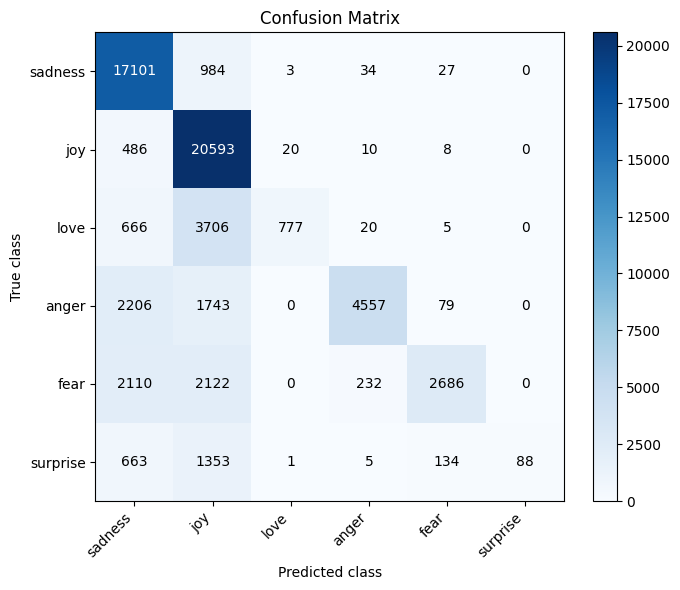

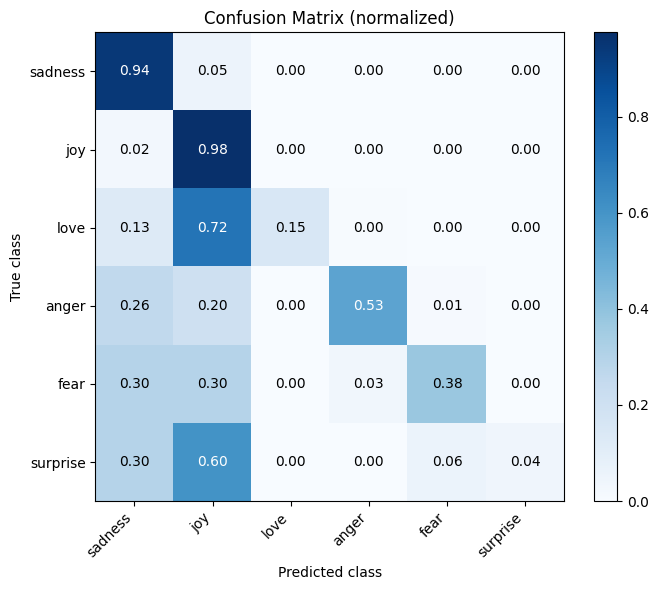

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-47-32_baseline


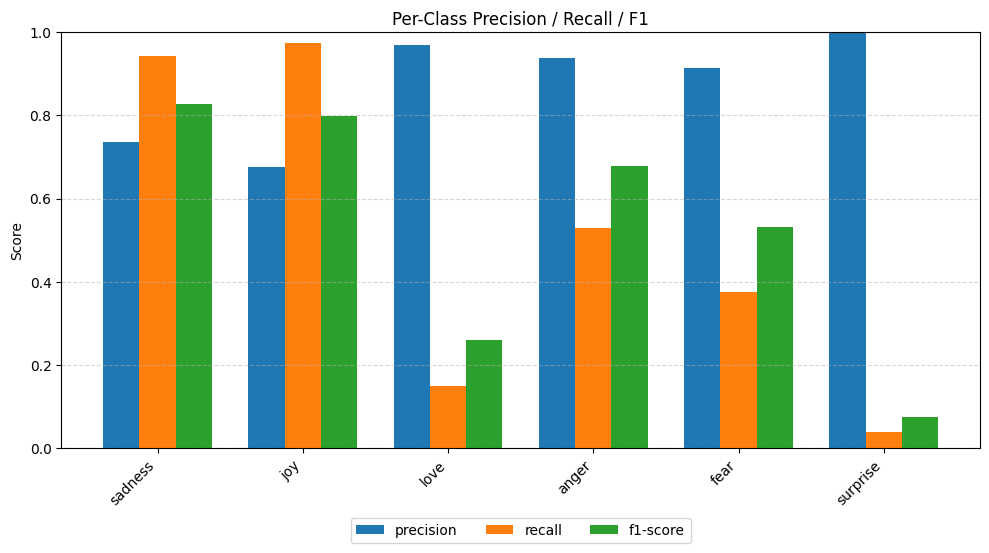

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-47-32_baseline
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv
{
  "trial_dir": "..\\artifacts\\trials\\2025-12-09_07-47-32_baseline",
  "metrics": {
    "train": {
      "accuracy": 0.7637167594735071,
      "macro_f1": 0.5737758462140014
    },
    "val": {
      "accuracy": 0.7372712999455285,
      "macro_f1": 0.5327357361700958
    },
    "test": {
      "accuracy": 0.7337829827456384,
      "macro_f1": 0.5284007807207195
    }
  },
  "leaderboard": "..\\artifacts\\outputs\\leaderboard.csv",
  "label_lookup": [
    {
      "label_id": 0,
      "label_name": "sadness"
    },
    {
      "label_id": 1,
      "label_name": "joy"
    },
    {
      "label_id": 2,
      "label_name": "love"
    },
    {
      "label_id": 3,
      "label_name": "anger"
    },
    {
      "label_id": 4,
      "label_name": "fear"
    },
    {
      "label_id": 5,
      "label_name": "surprise"
    }
  ]
}


In [4]:
baseline_result = run_trial(
    trial_tag="baseline",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1,1),
        "stop_words": None,
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": True,
    },
    seed=SEED
)

print(json.dumps(baseline_result, indent=2))


## Run optimization: Expand TF-IDF n-gram range to (1,2) to include bigrams that may capture short emotional phrases and improve minority-class detection.

[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-47-41_tfidf_1_2
[run_trial] Vector shapes: train (291286, 956430) val (62418, 956430) test (62419, 956430)
[run_trial] Performance:
  Train: {'accuracy': 0.7140336301779008, 'macro_f1': 0.47071790911707834}
  Val:   {'accuracy': 0.6704956903457336, 'macro_f1': 0.41221213527434797}
  Test:  {'accuracy': 0.6719588586808504, 'macro_f1': 0.4156984143525058}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7374    0.9194    0.8184     18149
         joy     0.5952    0.9908    0.7436     21117
        love     1.0000    0.0562    0.1065      5174
       anger     0.9458    0.2927    0.4471      8585
        fear     0.9038    0.2076    0.3376      7150
    surprise     1.0000    0.0209    0.0410      2244

    accuracy                         0.6720     62419
   macro avg     0.8637    0.4146    0.4157     62419
weighted avg     0.7682    0.6720    0.6000     624

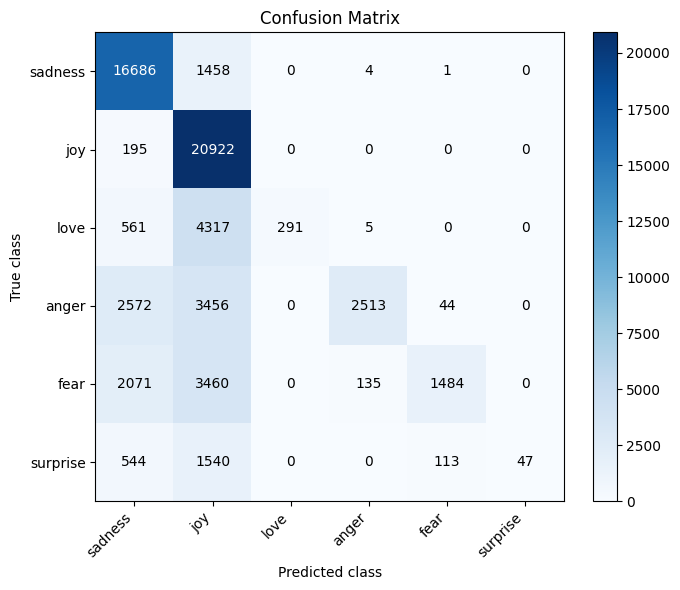

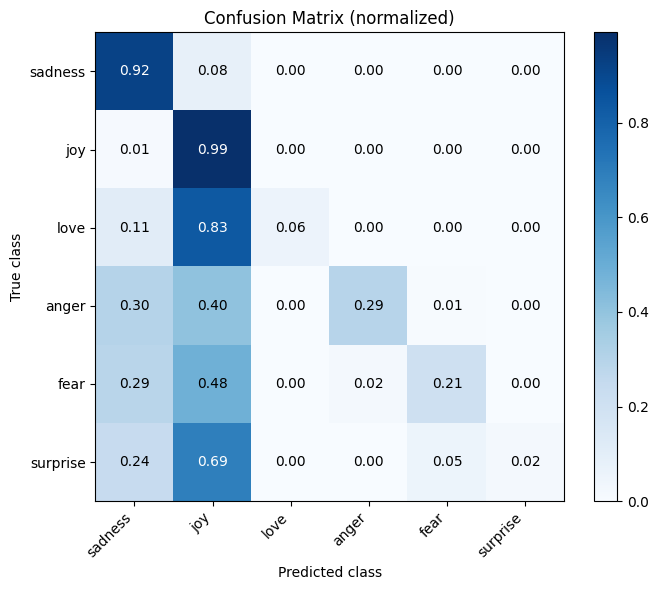

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-47-41_tfidf_1_2


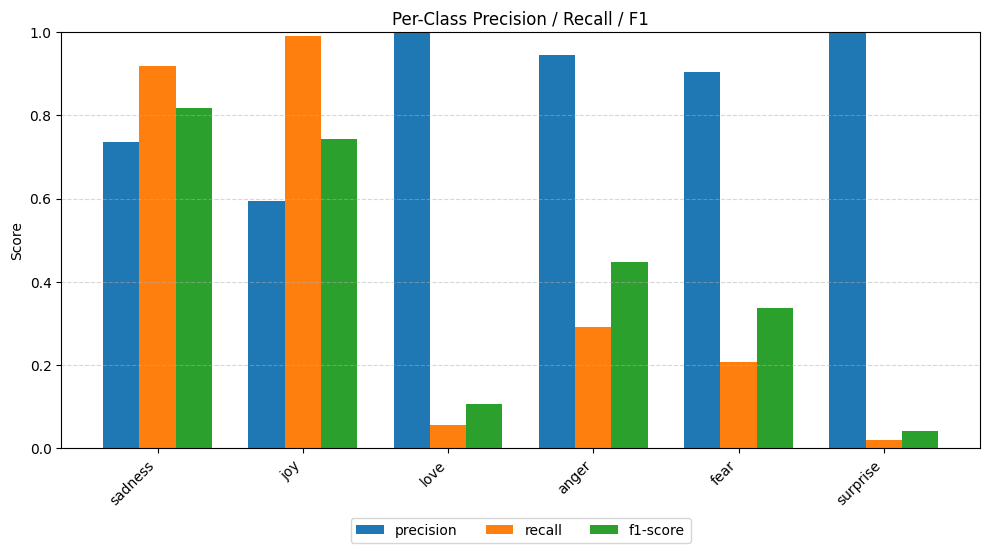

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-47-41_tfidf_1_2
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [5]:
trial_tfidf_1_2 = run_trial(
    trial_tag="tfidf_1_2",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": True,
    },
    seed=SEED,
)


## Run optimization: Apply `min_df=3` to remove very rare terms and reduce noise while retaining meaningful expressions.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-48-05_tfidf_1_2_min_df_3
[run_trial] Vector shapes: train (291286, 197872) val (62418, 197872) test (62419, 197872)
[run_trial] Performance:
  Train: {'accuracy': 0.8072100959194743, 'macro_f1': 0.6420054756863127}
  Val:   {'accuracy': 0.7617033548014995, 'macro_f1': 0.5773214878202791}
  Test:  {'accuracy': 0.7605857190919432, 'macro_f1': 0.5752338949566257}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7735    0.9494    0.8525     18149
         joy     0.6938    0.9817    0.8130     21117
        love     0.9803    0.1919    0.3210      5174
       anger     0.9426    0.5811    0.7190      8585
        fear     0.8885    0.4723    0.6167      7150
    surprise     1.0000    0.0691    0.1292      2244

    accuracy                         0.7606     62419
   macro avg     0.8798    0.5409    0.5752     62419
weighted avg     0.8082    0.7606    0.7237 

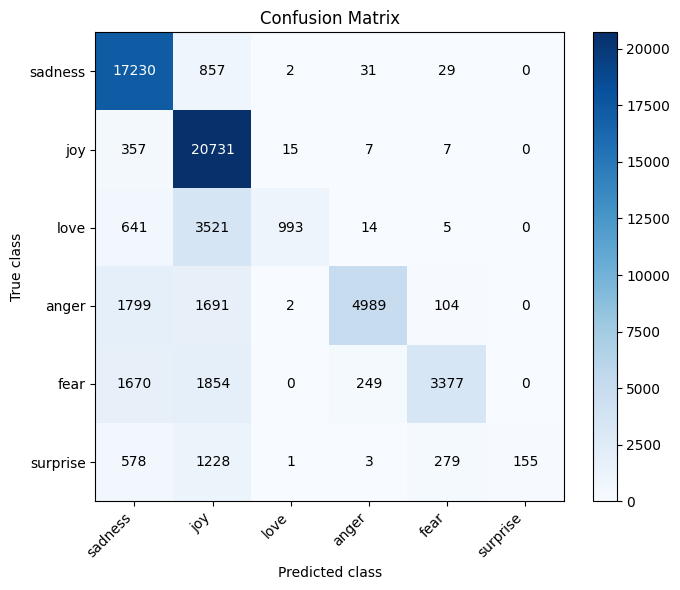

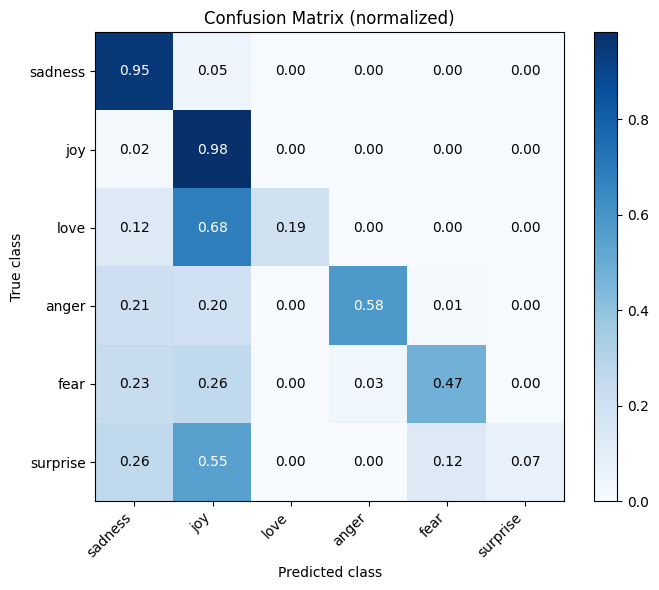

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-48-05_tfidf_1_2_min_df_3


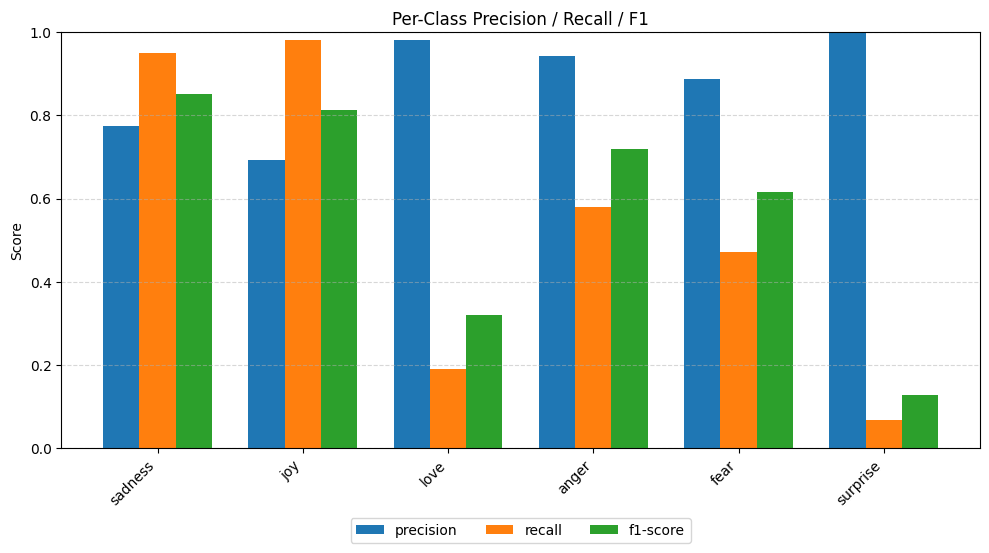

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-48-05_tfidf_1_2_min_df_3
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [6]:
trial_tfidf_1_2_min3 = run_trial(
    trial_tag="tfidf_1_2_min_df_3",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
        "min_df": 3,
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": True,
    },
    seed=SEED,
)


## Run optimization: Increase `min_df` to 5 to test whether a smaller, cleaner vocabulary improves overall balance.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-48-21_tfidf_1_2_min_df_5
[run_trial] Vector shapes: train (291286, 119423) val (62418, 119423) test (62419, 119423)
[run_trial] Performance:
  Train: {'accuracy': 0.8383993738113057, 'macro_f1': 0.7043878744851423}
  Val:   {'accuracy': 0.7993207087699061, 'macro_f1': 0.6484932524132031}
  Test:  {'accuracy': 0.7977378682772873, 'macro_f1': 0.6438370646746213}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.8088    0.9506    0.8740     18149
         joy     0.7323    0.9768    0.8371     21117
        love     0.9607    0.2880    0.4431      5174
       anger     0.9390    0.6905    0.7958      8585
        fear     0.8835    0.5931    0.7098      7150
    surprise     0.9922    0.1132    0.2032      2244

    accuracy                         0.7977     62419
   macro avg     0.8861    0.6020    0.6438     62419
weighted avg     0.8286    0.7977    0.7721 

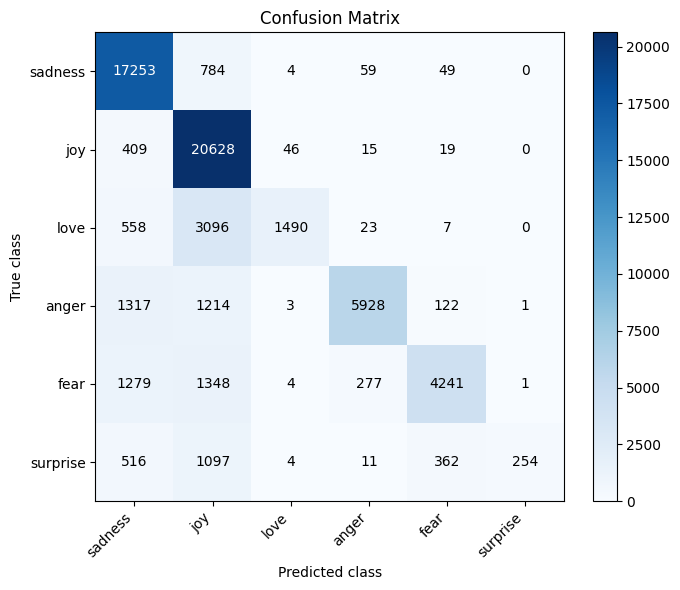

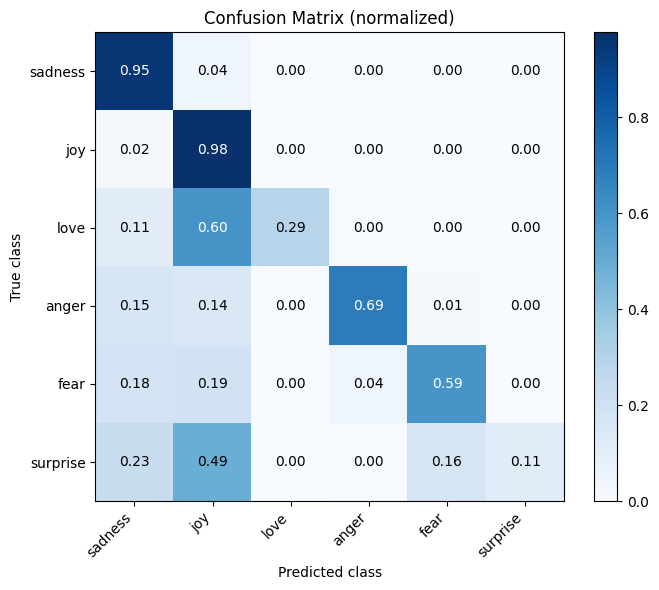

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-48-21_tfidf_1_2_min_df_5


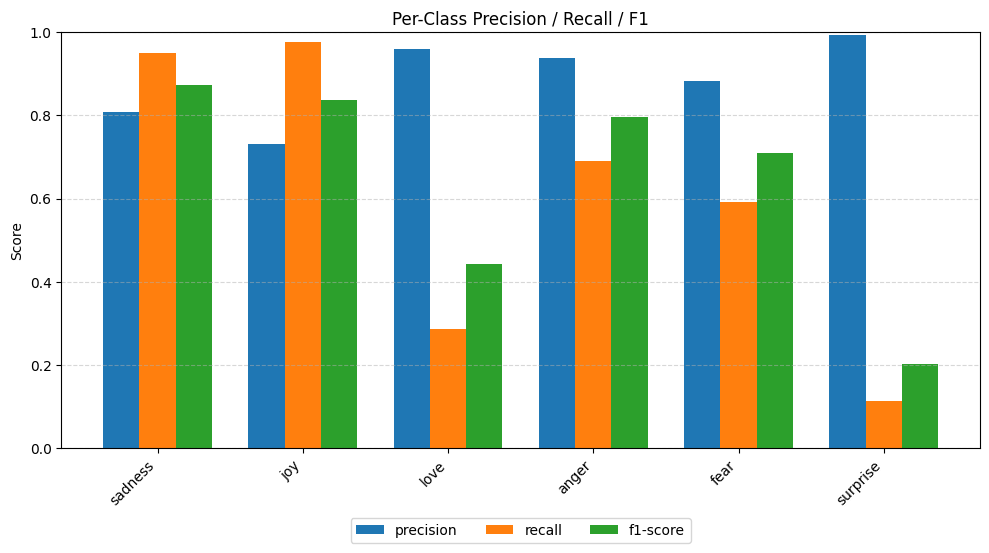

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-48-21_tfidf_1_2_min_df_5
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [7]:
trial_tfidf_1_2_min5 = run_trial(
    trial_tag="tfidf_1_2_min_df_5",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
        "min_df": 5,
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": True,
    },
    seed=SEED,
)


## Run optimization: Enable English stopword removal with bigrams to emphasize emotionally relevant terms over common filler words.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-48-34_tfidf_1_2_stopwords
[run_trial] Vector shapes: train (291286, 1073540) val (62418, 1073540) test (62419, 1073540)
[run_trial] Performance:
  Train: {'accuracy': 0.8031350631338272, 'macro_f1': 0.620455128729366}
  Val:   {'accuracy': 0.7408279662917748, 'macro_f1': 0.5377844694225656}
  Test:  {'accuracy': 0.7377080696582772, 'macro_f1': 0.5334161279693971}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7791    0.9502    0.8562     18149
         joy     0.6580    0.9881    0.7900     21117
        love     0.9974    0.1455    0.2540      5174
       anger     0.9435    0.4998    0.6535      8585
        fear     0.8795    0.3860    0.5365      7150
    surprise     1.0000    0.0584    0.1103      2244

    accuracy                         0.7377     62419
   macro avg     0.8762    0.5047    0.5334     62419
weighted avg     0.7983    0.7377    0.69

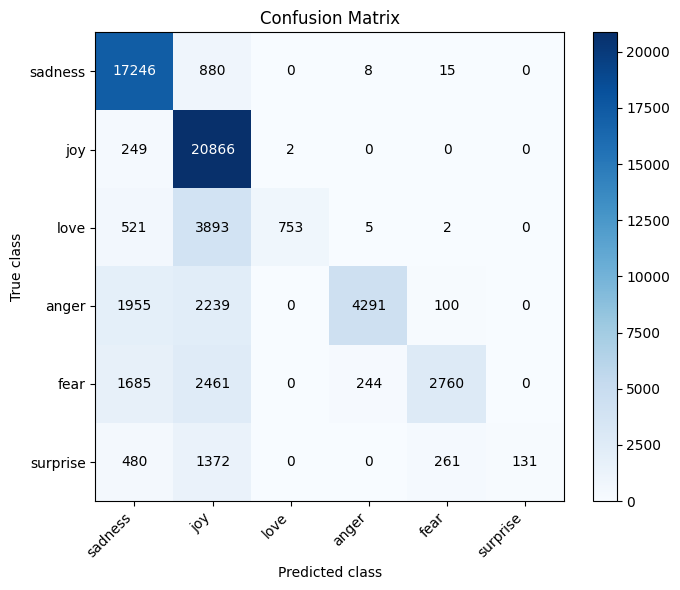

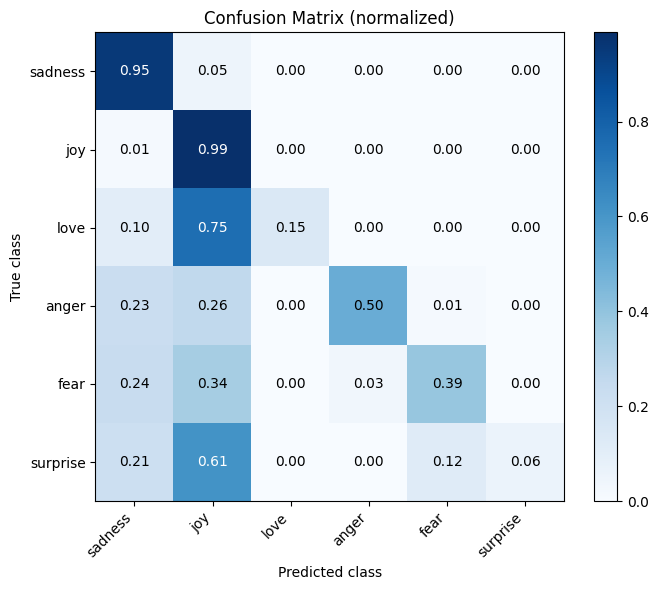

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-48-34_tfidf_1_2_stopwords


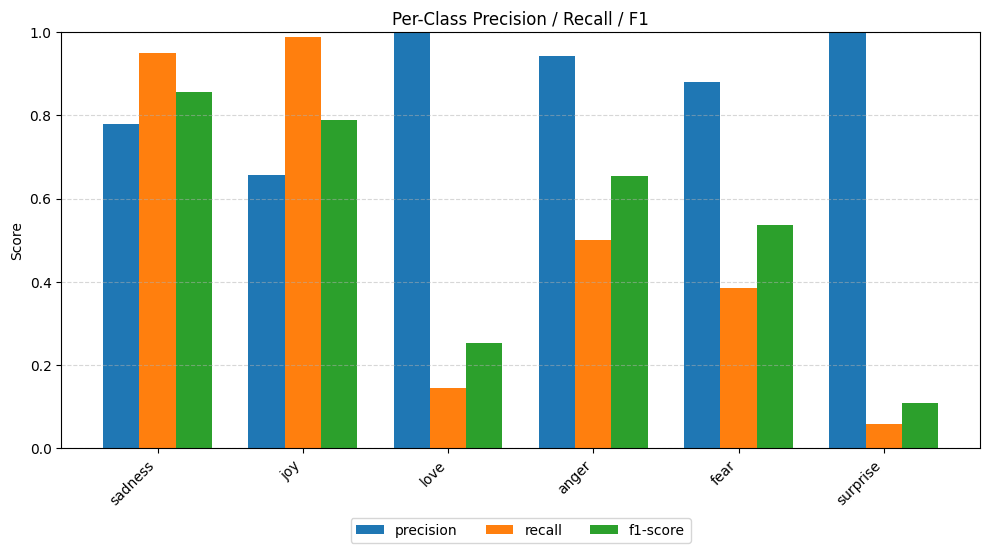

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-48-34_tfidf_1_2_stopwords
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [8]:
trial_tfidf_1_2_stop = run_trial(
    trial_tag="tfidf_1_2_stopwords",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": "english",
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": True,
    },
    seed=SEED,
)


## Run optimization: Reduce the NB smoothing parameter (α=0.5) to rely more on actual word frequencies and possibly boost minority-class recall.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-48-55_nb_alpha_0_5
[run_trial] Vector shapes: train (291286, 956430) val (62418, 956430) test (62419, 956430)
[run_trial] Performance:
  Train: {'accuracy': 0.7898731830572016, 'macro_f1': 0.6013657253699545}
  Val:   {'accuracy': 0.7058861225928418, 'macro_f1': 0.47804548485495485}
  Test:  {'accuracy': 0.7080856790400358, 'macro_f1': 0.4808492236318282}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7391    0.9381    0.8268     18149
         joy     0.6419    0.9855    0.7774     21117
        love     0.9756    0.1003    0.1819      5174
       anger     0.9342    0.4137    0.5735      8585
        fear     0.8664    0.3092    0.4558      7150
    surprise     0.9878    0.0361    0.0696      2244

    accuracy                         0.7081     62419
   macro avg     0.8575    0.4638    0.4808     62419
weighted avg     0.7762    0.7081    0.6521     6

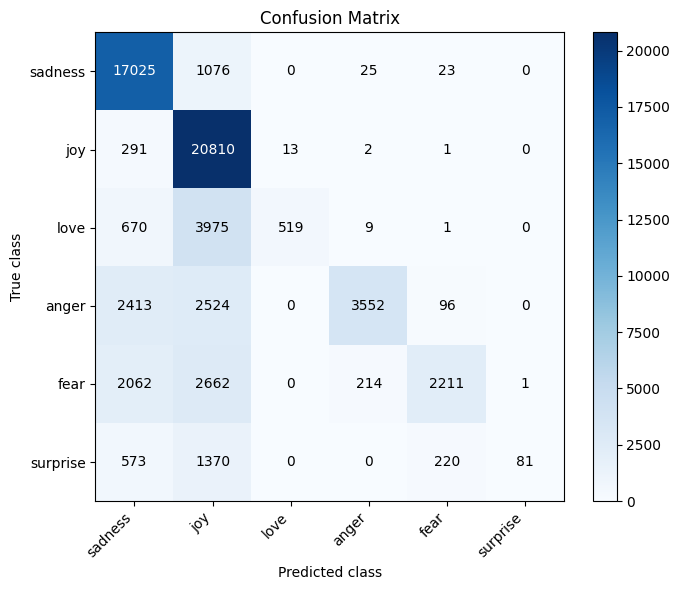

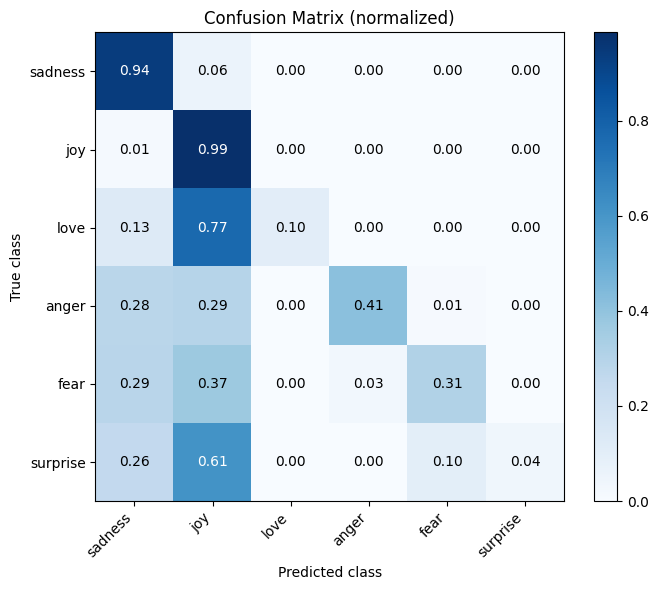

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-48-55_nb_alpha_0_5


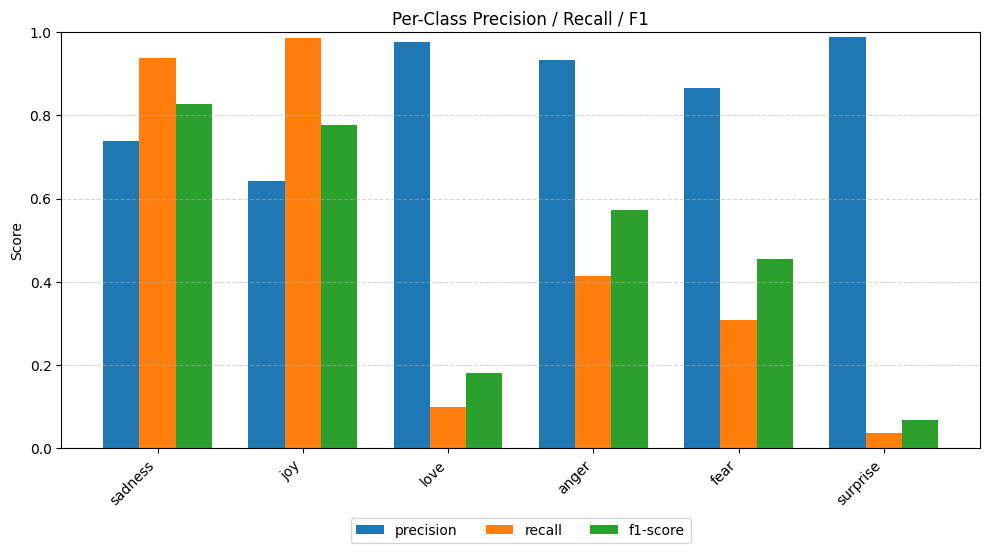

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-48-55_nb_alpha_0_5
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [9]:
trial_nb_alpha_0_5 = run_trial(
    trial_tag="nb_alpha_0_5",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
    },
    nb_params={
        "alpha": 0.5,
        "fit_prior": True,
    },
    seed=SEED,
)


## Run optimization: Set `fit_prior=False` so all classes are treated equally, aiming to improve recall for low-support emotions.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-49-18_nb_alpha_0_5_noprior
[run_trial] Vector shapes: train (291286, 956430) val (62418, 956430) test (62419, 956430)
[run_trial] Performance:
  Train: {'accuracy': 0.8710888954498328, 'macro_f1': 0.7641373073868395}
  Val:   {'accuracy': 0.7670703963600244, 'macro_f1': 0.609160902175844}
  Test:  {'accuracy': 0.7654880725420145, 'macro_f1': 0.6047060001259923}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.7795    0.9410    0.8527     18149
         joy     0.7078    0.9706    0.8186     21117
        love     0.8547    0.2466    0.3828      5174
       anger     0.9237    0.5920    0.7215      8585
        fear     0.8454    0.4972    0.6262      7150
    surprise     0.8352    0.1310    0.2265      2244

    accuracy                         0.7655     62419
   macro avg     0.8244    0.5631    0.6047     62419
weighted avg     0.7909    0.7655    0.7357

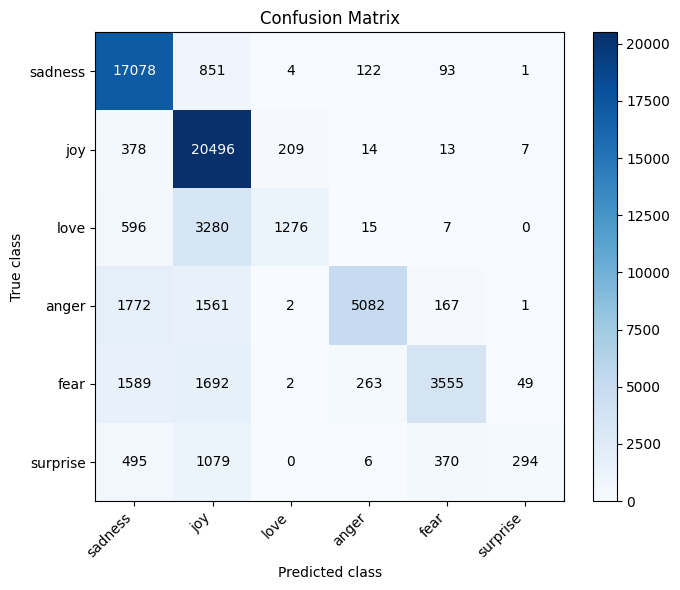

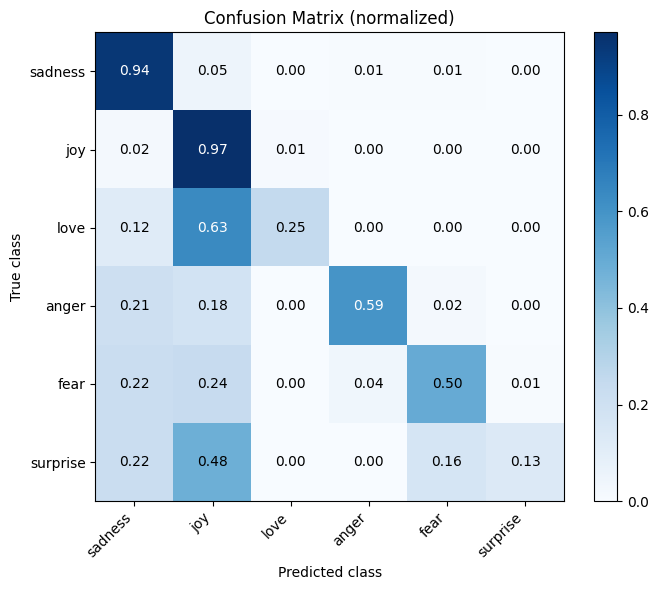

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-49-18_nb_alpha_0_5_noprior


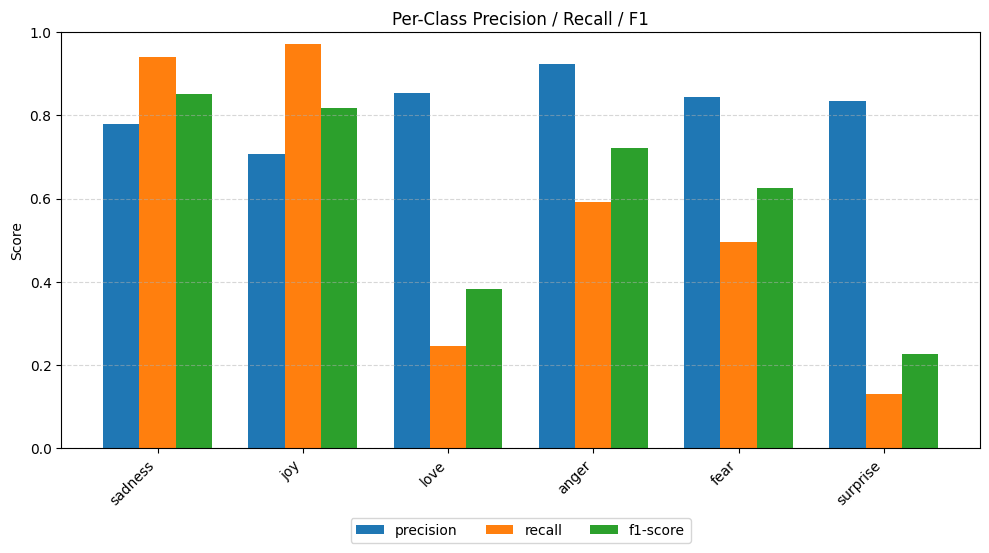

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-49-18_nb_alpha_0_5_noprior
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [10]:
trial_nb_alpha_0_5_noprior = run_trial(
    trial_tag="nb_alpha_0_5_noprior",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
    },
    nb_params={
        "alpha": 0.5,
        "fit_prior": False,
    },
    seed=SEED,
)


## Run optimization: Best TF-IDF (1–2, min_df=5) + `fit_prior=False` to reduce bias toward frequent emotions.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-49-41_tfidf_1_2_min_df_5_noprior
[run_trial] Vector shapes: train (291286, 119423) val (62418, 119423) test (62419, 119423)
[run_trial] Performance:
  Train: {'accuracy': 0.9063635052834671, 'macro_f1': 0.8557024664589772}
  Val:   {'accuracy': 0.864670447627287, 'macro_f1': 0.7939710102546096}
  Test:  {'accuracy': 0.8643041381630593, 'macro_f1': 0.7906590451122818}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.8959    0.9304    0.9128     18149
         joy     0.8544    0.9273    0.8894     21117
        love     0.7811    0.6533    0.7115      5174
       anger     0.8887    0.8657    0.8770      8585
        fear     0.8369    0.8119    0.8242      7150
    surprise     0.8431    0.3855    0.5291      2244

    accuracy                         0.8643     62419
   macro avg     0.8500    0.7623    0.7907     62419
weighted avg     0.8627    0.8643    

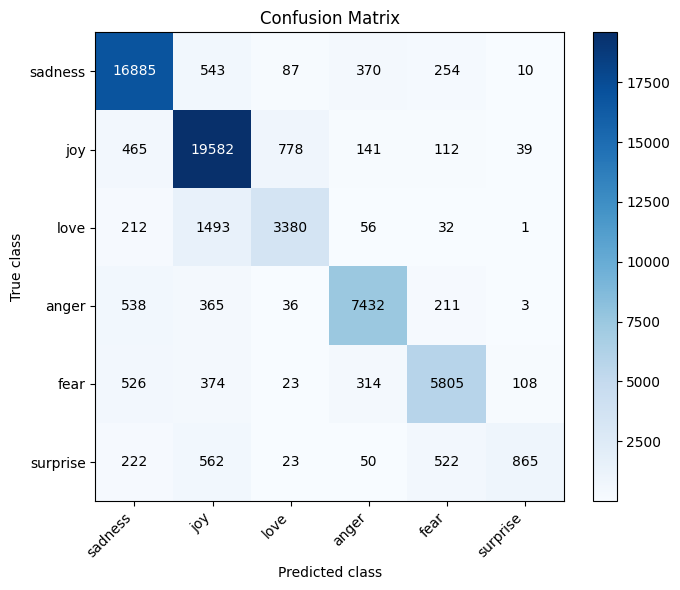

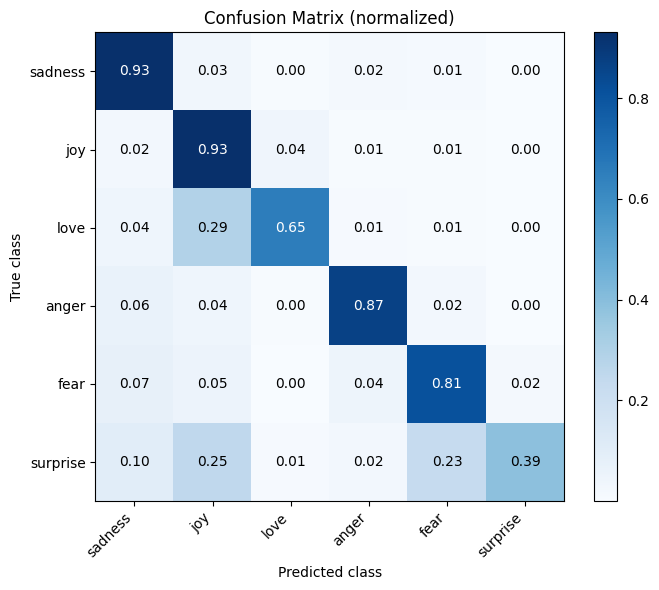

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-49-41_tfidf_1_2_min_df_5_noprior


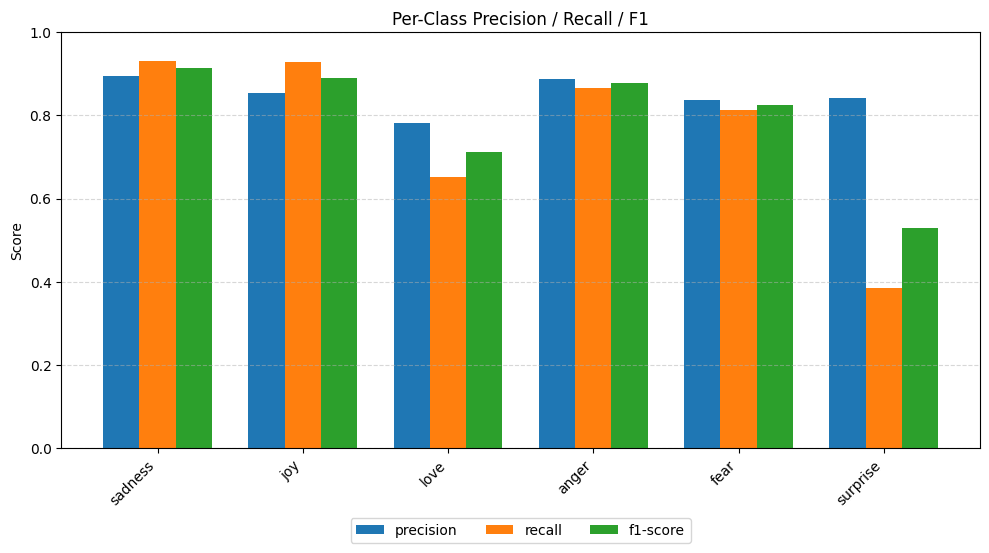

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-49-41_tfidf_1_2_min_df_5_noprior
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [11]:
trial_tfidf_1_2_min5_noprior = run_trial(
    trial_tag="tfidf_1_2_min_df_5_noprior",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
        "min_df": 5,
    },
    nb_params={
        "alpha": 1.0,
        "fit_prior": False,
    },
    seed=SEED,
)


## Run optimization: Best TF-IDF (1–2, min_df=5) + `fit_prior=False` + reduce NB smoothing (α=0.5) to increase sensitivity to distinctive low-support terms.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-49-54_tfidf_1_2_min_df_5_noprior_a0_5
[run_trial] Vector shapes: train (291286, 119423) val (62418, 119423) test (62419, 119423)
[run_trial] Performance:
  Train: {'accuracy': 0.9172737447045172, 'macro_f1': 0.8875935316651216}
  Val:   {'accuracy': 0.8702457624403217, 'macro_f1': 0.819814730119301}
  Test:  {'accuracy': 0.8698793636552973, 'macro_f1': 0.8186908896080382}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.9266    0.9095    0.9180     18149
         joy     0.9026    0.8855    0.8940     21117
        love     0.6971    0.7905    0.7409      5174
       anger     0.8656    0.8937    0.8794      8585
        fear     0.8158    0.8415    0.8284      7150
    surprise     0.7361    0.5842    0.6514      2244

    accuracy                         0.8699     62419
   macro avg     0.8240    0.8175    0.8187     62419
weighted avg     0.8715    0.869

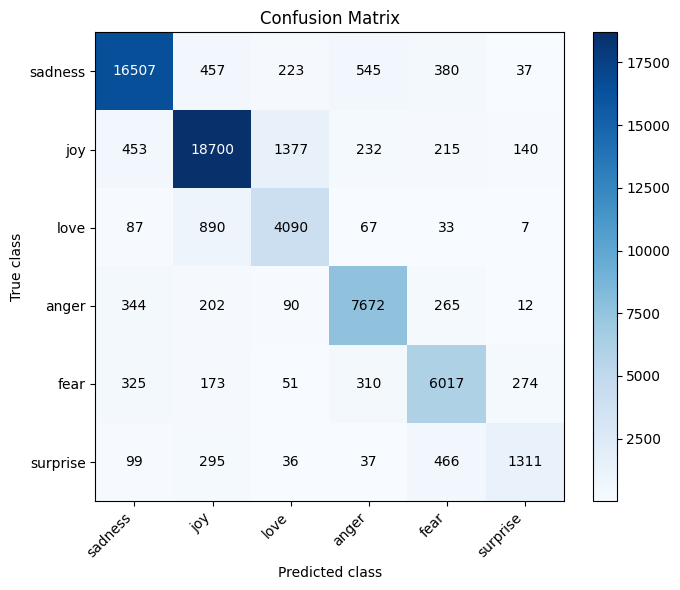

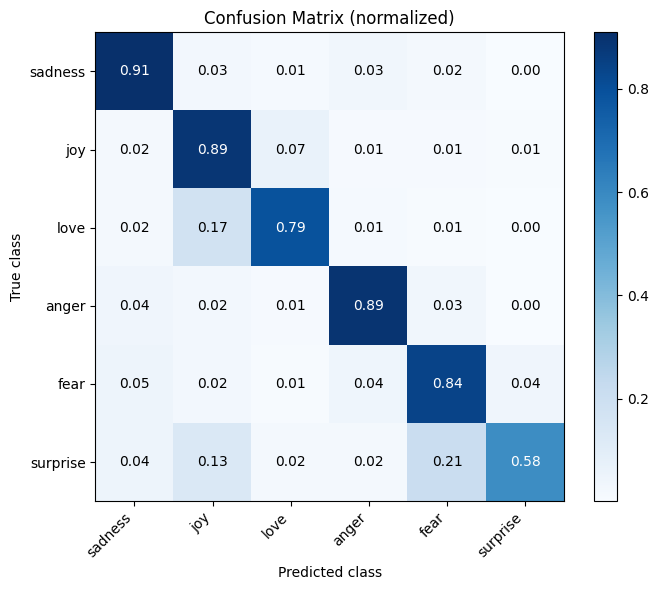

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-49-54_tfidf_1_2_min_df_5_noprior_a0_5


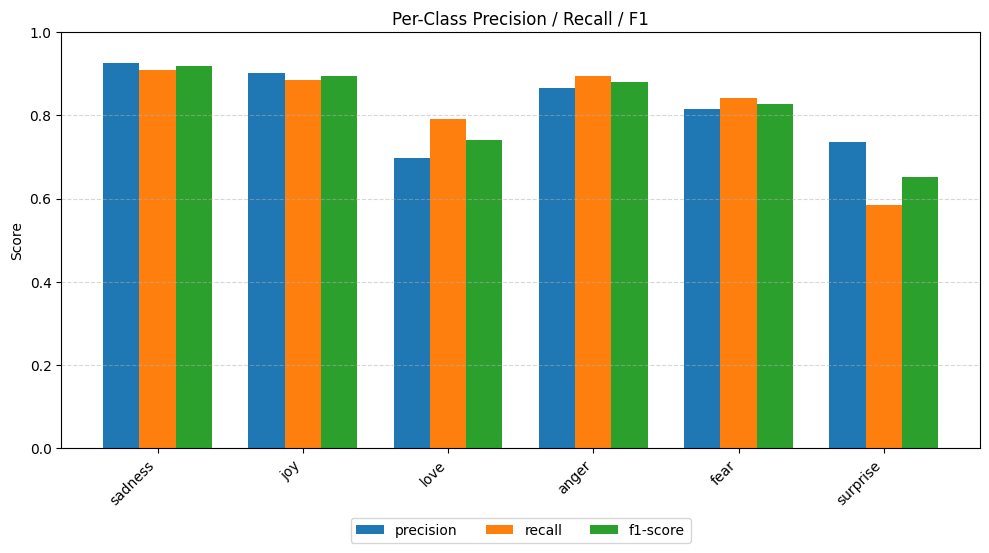

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-49-54_tfidf_1_2_min_df_5_noprior_a0_5
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [12]:
trial_tfidf_1_2_min5_noprior_a05 = run_trial(
    trial_tag="tfidf_1_2_min_df_5_noprior_a0_5",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
        "min_df": 5,
    },
    nb_params={
        "alpha": 0.5,
        "fit_prior": False,
    },
    seed=SEED,
)


## Run optimization: Add `sublinear_tf=True` to best TF-IDF to dampen very frequent words so rare emotional cues get relatively more weight.


[run_trial] Trial directory: ..\artifacts\trials\2025-12-09_07-50-08_tfidf_1_2_min_df_5_sublinear_noprior
[run_trial] Vector shapes: train (291286, 119423) val (62418, 119423) test (62419, 119423)
[run_trial] Performance:
  Train: {'accuracy': 0.9177372067315285, 'macro_f1': 0.8883114027021474}
  Val:   {'accuracy': 0.8706142458906084, 'macro_f1': 0.8203480666803235}
  Test:  {'accuracy': 0.870247841202198, 'macro_f1': 0.8190563765621328}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

     sadness     0.9273    0.9097    0.9184     18149
         joy     0.9033    0.8852    0.8941     21117
        love     0.6978    0.7922    0.7420      5174
       anger     0.8661    0.8946    0.8801      8585
        fear     0.8152    0.8429    0.8289      7150
    surprise     0.7345    0.5842    0.6508      2244

    accuracy                         0.8702     62419
   macro avg     0.8240    0.8181    0.8191     62419
weighted avg     0.8720    

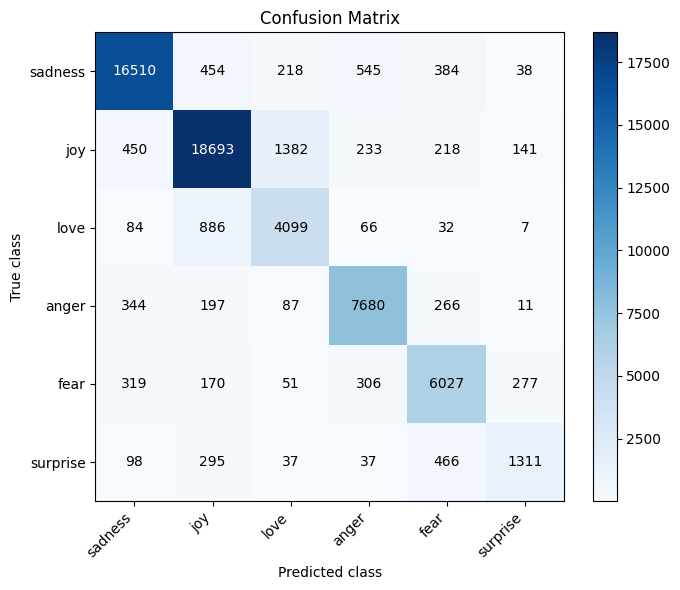

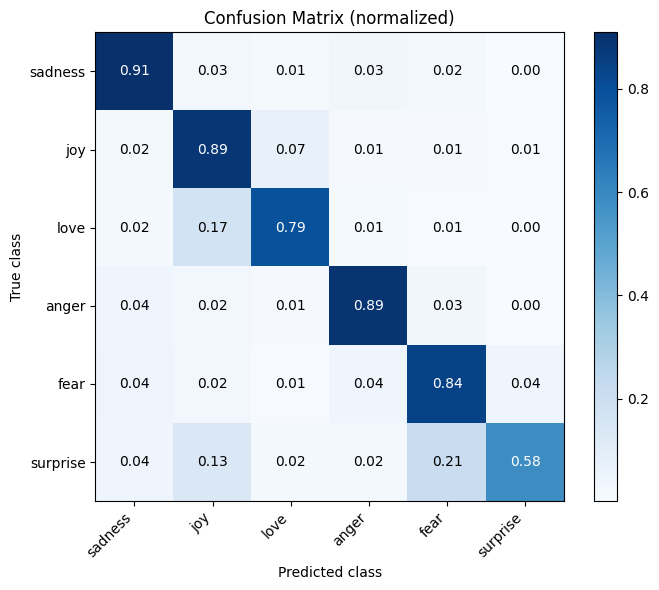

[run_trial] Saved raw and normalized confusion matrices to ..\artifacts\trials\2025-12-09_07-50-08_tfidf_1_2_min_df_5_sublinear_noprior


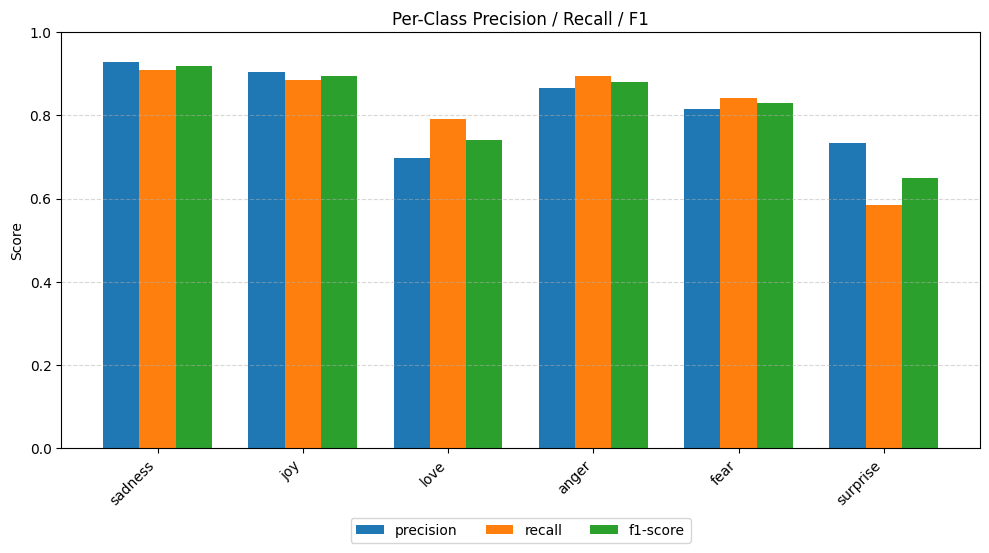

[run_trial] Saved artifacts to ..\artifacts\trials\2025-12-09_07-50-08_tfidf_1_2_min_df_5_sublinear_noprior
[run_trial] Leaderboard updated at ..\artifacts\outputs\leaderboard.csv


In [13]:
trial_tfidf_1_2_min5_sublinear_noprior = run_trial(
    trial_tag="tfidf_1_2_min_df_5_sublinear_noprior",
    tfidf_params={
        "lowercase": True,
        "ngram_range": (1, 2),
        "stop_words": None,
        "min_df": 5,
        "sublinear_tf": True,
    },
    nb_params={
        "alpha": 0.5,
        "fit_prior": False,
    },
    seed=SEED,
)


## Promote best-performing model to /artifacts/models directory

In [14]:
# Promote best-performing NB text model

lb_path = OUTPUTS_DIR / "leaderboard.csv"
lb = pd.read_csv(lb_path)

# Pick the best row by test_macro_f1
best_row = lb.sort_values("test_macro_f1", ascending=False).iloc[0]

best_tag = best_row["trial_tag"]
best_trial_dir = Path(best_row["artifacts_dir"])

print(f"Best trial (by test_macro_f1): {best_tag}")
print(f"Source artifacts: {best_trial_dir}")

# Copy all files from the best trial into ./artifacts/models/
for src in best_trial_dir.glob("*"):
    dst = MODELS / src.name
    shutil.copy2(src, dst)

# Normalize / rename the two key joblib files
nb_src = MODELS / "nb.joblib"
tfidf_src = MODELS / "tfidf.joblib"

if nb_src.exists():
    nb_dst = MODELS / "best_nb.joblib"
    nb_src.replace(nb_dst)
    print("Saved NB model ->", nb_dst)
else:
    print("WARNING: nb.joblib was not found in best trial artifacts.")

if tfidf_src.exists():
    tfidf_dst = MODELS / "best_tfidf.joblib"
    tfidf_src.replace(tfidf_dst)
    print("Saved TF-IDF vectorizer ->", tfidf_dst)
else:
    print("WARNING: tfidf.joblib was not found in best trial artifacts.")

# Snapshot metrics
metrics_src = MODELS / "metrics.json"

if metrics_src.exists():
    metrics_dst = MODELS / "best_metrics.json"
    metrics_src.replace(metrics_dst)
    print("Saved metrics ->", metrics_dst)
else:
    print("WARNING: metrics.json not found in best trial artifacts.")

print("Promotion complete. Artifacts are in:", MODELS.resolve())


Best trial (by test_macro_f1): tfidf_1_2_min_df_5_sublinear_noprior
Source artifacts: ..\artifacts\trials\2025-12-09_07-50-08_tfidf_1_2_min_df_5_sublinear_noprior
Saved NB model -> ..\artifacts\models\best_nb.joblib
Saved TF-IDF vectorizer -> ..\artifacts\models\best_tfidf.joblib
Saved metrics -> ..\artifacts\models\best_metrics.json
Promotion complete. Artifacts are in: C:\Code\Text-Emotion-NB\artifacts\models
